In [506]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder, StandardScaler,\
FunctionTransformer

from sklearn.pipeline import Pipeline

from sklearn.impute import MissingIndicator, SimpleImputer

from sklearn.compose import ColumnTransformer,  make_column_selector as selector

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV 
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, \
AdaBoostClassifier, GradientBoostingClassifier

from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# plot_confusion_matrix is a handy visual tool, added in the latest version of scikit-learn
# if you are running an older version, comment out this line and just use confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve

In [392]:
sub = pd.read_csv('data/SubmissionFormat.csv')
X_te = pd.read_csv('data/TestSetValues.csv')
train_label = pd.read_csv('data/TrainingSetLabels.csv')
X_t = pd.read_csv('data/TrainingSetValues.csv')

In [393]:
sub.head()

,id,status_group
0,50785,predicted label
1,51630,predicted label
2,17168,predicted label
3,45559,predicted label
4,49871,predicted label


In [394]:
X_te.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,...,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,...,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,...,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [395]:
train_label.status_group.value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

In [396]:
y_train = train_label.status_group

In [398]:
X_t.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group'],
      dtype='object')

In [580]:
categorical = selector(dtype_include=object)
X_t_cat = X_t[categorical(X_t)]

for x in X_t_cat:
    print('{}: {} unique values'.format(x, len(X_t_cat[x].unique())))

date_recorded: 356 unique values
funder: 1898 unique values
installer: 2146 unique values
wpt_name: 37400 unique values
basin: 9 unique values
subvillage: 19288 unique values
region: 21 unique values
lga: 125 unique values
ward: 2092 unique values
public_meeting: 3 unique values
recorded_by: 1 unique values
scheme_management: 13 unique values
scheme_name: 2697 unique values
permit: 3 unique values
extraction_type: 18 unique values
extraction_type_group: 13 unique values
extraction_type_class: 7 unique values
management: 12 unique values
management_group: 5 unique values
payment: 7 unique values
payment_type: 7 unique values
water_quality: 8 unique values
quality_group: 6 unique values
quantity: 5 unique values
quantity_group: 5 unique values
source: 10 unique values
source_type: 7 unique values
source_class: 3 unique values
waterpoint_type: 7 unique values
waterpoint_type_group: 6 unique values


In [399]:
X_t.management.value_counts()

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64

In [400]:
X_t.management_group.value_counts()

user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: management_group, dtype: int64

In [401]:
X_t.payment.value_counts()

never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64

In [402]:
X_t.payment_type.value_counts()

never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64

In [403]:
X_t.water_quality.value_counts()

soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64

In [404]:
X_t.quality_group.value_counts()

good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64

In [405]:
X_t.quantity.value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64

In [406]:
X_t.quantity_group.value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64

In [407]:
X_t.waterpoint_type.value_counts()

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64

In [408]:
X_t.waterpoint_type_group.value_counts()

communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64

In [409]:
X_t.source.value_counts()

spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64

In [410]:
X_t.source_class.value_counts()

groundwater    45794
surface        13328
unknown          278
Name: source_class, dtype: int64

In [411]:
X_t.source_type.value_counts()

spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64

In [412]:
X_t.extraction_type.value_counts()

gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

In [413]:
X_t.extraction_type_class.value_counts()

gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: extraction_type_class, dtype: int64

In [414]:
X_t.extraction_type_group.value_counts()

gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
india mark iii        98
Name: extraction_type_group, dtype: int64

In [415]:
X_t.scheme_management.value_counts()

VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

In [416]:
X_t.scheme_name.value_counts()

K                           682
None                        644
Borehole                    546
Chalinze wate               405
M                           400
                           ... 
Tiflo masaki branch line      1
BL Siha Sec                   1
Tamp                          1
Mchangani                     1
Itoo water supply             1
Name: scheme_name, Length: 2696, dtype: int64

In [417]:
X_t.recorded_by.value_counts()

GeoData Consultants Ltd    59400
Name: recorded_by, dtype: int64

In [418]:
X_t.ward.value_counts()

Igosi        307
Imalinyi     252
Siha Kati    232
Mdandu       231
Nduruma      217
            ... 
Korongoni      1
Izia           1
Matarawe       1
Kitete         1
Kapilula       1
Name: ward, Length: 2092, dtype: int64

In [419]:
X_t.lga.value_counts()

Njombe          2503
Arusha Rural    1252
Moshi Rural     1251
Bariadi         1177
Rungwe          1106
                ... 
Moshi Urban       79
Kigoma Urban      71
Arusha Urban      63
Lindi Urban       21
Nyamagana          1
Name: lga, Length: 125, dtype: int64

In [420]:
X_t.district_code.value_counts()

1     12203
2     11173
3      9998
4      8999
5      4356
6      4074
7      3343
8      1043
30      995
33      874
53      745
43      505
13      391
23      293
63      195
62      109
60       63
0        23
80       12
67        6
Name: district_code, dtype: int64

In [421]:
X_t.region_code.value_counts()

11    5300
17    5011
12    4639
3     4379
5     4040
18    3324
19    3047
2     3024
16    2816
10    2640
4     2513
1     2201
13    2093
14    1979
20    1969
15    1808
6     1609
21    1583
80    1238
60    1025
90     917
7      805
99     423
9      390
24     326
8      300
40       1
Name: region_code, dtype: int64

In [422]:
X_t.region.value_counts()

Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: region, dtype: int64

In [423]:
X_t.subvillage.value_counts()

Madukani      508
Shuleni       506
Majengo       502
Kati          373
Mtakuja       262
             ... 
Samaria C       1
Solwa           1
Mubamba A       1
Nyang'Anga      1
Kudiboya        1
Name: subvillage, Length: 19287, dtype: int64

In [424]:
X_t.num_private.value_counts()

0      58643
6         81
1         73
5         46
8         46
       ...  
180        1
213        1
23         1
55         1
94         1
Name: num_private, Length: 65, dtype: int64

In [425]:
X_t.wpt_name.value_counts()

none               3563
Shuleni            1748
Zahanati            830
Msikitini           535
Kanisani            323
                   ... 
Kwaephraim            1
Kwa Mwandindi         1
Kazinyingi            1
Kwa Daniel Mobe       1
Kwa Frida Minja       1
Name: wpt_name, Length: 37400, dtype: int64

In [426]:
X_t.installer.value_counts()

DWE                  17402
Government            1825
RWE                   1206
Commu                 1060
DANIDA                1050
                     ...  
Jumanne Siabo            1
kw                       1
Ardhi Water Wells        1
TAIPO                    1
WSSP                     1
Name: installer, Length: 2145, dtype: int64

In [427]:
X_t.gps_height.value_counts()

 0       20438
-15         60
-16         55
-13         55
-20         52
         ...  
 2285        1
 2424        1
 2552        1
 2413        1
 2385        1
Name: gps_height, Length: 2428, dtype: int64

In [428]:
X_t.funder.value_counts()

Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
                          ... 
Selestine Mganga             1
Ramadhani Nyambizi           1
Makli                        1
Sumriy                       1
Villages                     1
Name: funder, Length: 1897, dtype: int64

In [429]:
X_t.date_recorded.value_counts()

2011-03-15    572
2011-03-17    558
2013-02-03    546
2011-03-14    520
2011-03-16    513
             ... 
2002-10-14      1
2012-01-21      1
2011-09-20      1
2011-09-28      1
2011-09-21      1
Name: date_recorded, Length: 356, dtype: int64

In [430]:
dropped_features = [
    'id',
    'management',
    'payment_type',
    'water_quality',
    'quantity',
    'waterpoint_type_group',
    'source',
    'source_type',
    'extraction_type',
    'extraction_type_group',
    'scheme_name',
    'recorded_by',
    'ward',
    'district_code',
    'region_code',
    'subvillage',
    'num_private',
    'wpt_name',
    'latitude',
    'longitude',
    'funder',
    'installer',
    'date_recorded',
    'public_meeting'
]

In [431]:
X_train = X_t.drop(dropped_features, 
                   axis=1)

X_test = X_te.drop(dropped_features,
                  axis=1)

In [432]:
X_train.head()

,id,amount_tsh,gps_height,basin,region,lga,population,scheme_management,permit,construction_year,extraction_type_class,management_group,payment,quality_group,quantity_group,source_class,waterpoint_type
0,69572,6000.0,1390,Lake Nyasa,Iringa,Ludewa,109,VWC,False,1999,gravity,user-group,pay annually,good,enough,groundwater,communal standpipe
1,8776,0.0,1399,Lake Victoria,Mara,Serengeti,280,Other,True,2010,gravity,user-group,never pay,good,insufficient,surface,communal standpipe
2,34310,25.0,686,Pangani,Manyara,Simanjiro,250,VWC,True,2009,gravity,user-group,pay per bucket,good,enough,surface,communal standpipe multiple
3,67743,0.0,263,Ruvuma / Southern Coast,Mtwara,Nanyumbu,58,VWC,True,1986,submersible,user-group,never pay,good,dry,groundwater,communal standpipe multiple
4,19728,0.0,0,Lake Victoria,Kagera,Karagwe,0,NaN,True,0,gravity,other,never pay,good,seasonal,surface,communal standpipe


In [433]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   gps_height             59400 non-null  int64  
 3   basin                  59400 non-null  object 
 4   region                 59400 non-null  object 
 5   lga                    59400 non-null  object 
 6   population             59400 non-null  int64  
 7   scheme_management      55523 non-null  object 
 8   permit                 56344 non-null  object 
 9   construction_year      59400 non-null  int64  
 10  extraction_type_class  59400 non-null  object 
 11  management_group       59400 non-null  object 
 12  payment                59400 non-null  object 
 13  quality_group          59400 non-null  object 
 14  quantity_group         59400 non-null  object 
 15  so

In [438]:
X_train.construction_year = X_train.construction_year.map(str).astype(object)
X_train.drop('id', axis=1, inplace=True)

In [439]:
# def grab_numeric(df):
#     return df.select_dtypes(include=['float64', 'int64'])

# GrabNumeric = FunctionTransformer(grab_numeric)

# pipe = Pipeline([
#     ('num',GrabNumeric),
#     ('ss', StandardScaler())
# ])
# pipe.fit_transform(X_train)

In [444]:
numeric_pipe = Pipeline([
    ('num_impute', SimpleImputer(strategy='mean')),
    ('ss', StandardScaler())
])

category_pipe = Pipeline([
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

In [454]:
Preprocessing = ColumnTransformer(transformers=[
    ('num_trans', numeric_pipe, selector(dtype_include=np.number)),
    ('cat_trans', category_pipe, selector(dtype_include=object))
],remainder='passthrough')

In [455]:
class Model():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

In [456]:
baseline_model = Pipeline([
    ('preprocessing', Preprocessing),
    ('baseline', DummyClassifier(strategy='most_frequent'))
])

baseline_model_pipe = Model(baseline_model,model_name='baseline',X=X_train,y=y_train)

In [457]:
baseline_model_pipe.print_cv_summary()

CV Results for `baseline` model:
            0.54308 ± 0.00005 accuracy
        


In [459]:
logreg_model = Pipeline([
    ('preprocessing', Preprocessing),
    ('lr', LogisticRegression(random_state=42, max_iter=10000))
])

logreg_model_pipe = Model(logreg_model,model_name='lr',X=X_train,y=y_train)

In [461]:
logreg_model_pipe.print_cv_summary()

CV Results for `lr` model:
            0.74643 ± 0.00654 accuracy
        


In [463]:
dt_model = Pipeline([
    ('preprocessing', Preprocessing),
    ('dt', DecisionTreeClassifier(random_state=42))
])

dt_model_pipe = Model(dt_model,model_name='dt', X=X_train,y=y_train)

In [465]:
dt_model_pipe.print_cv_summary()

CV Results for `dt` model:
            0.75668 ± 0.00593 accuracy
        


In [483]:
params = {
    'dt__criterion':['gini','entropy','log_loss'],
    'dt__max_depth':[None,5,10,25,50,75,100],
    'dt__min_samples_split':[2,5,10,15,20,25],
    'dt__min_samples_leaf':[1,3,5,10,15,20],
}

gs_dt = GridSearchCV(estimator=dt_model, param_grid=params,verbose=2)

In [484]:
gs_dt.fit(X_train, y_train)

Fitting 5 folds for each of 756 candidates, totalling 3780 fits
[CV] dt__criterion=gini, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  dt__criterion=gini, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=2, total=   4.7s
[CV] dt__criterion=gini, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s


[CV]  dt__criterion=gini, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=2, total=   4.9s
[CV] dt__criterion=gini, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=2 
[CV]  dt__criterion=gini, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=2, total=   4.9s
[CV] dt__criterion=gini, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=2 
[CV]  dt__criterion=gini, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=2, total=   5.0s
[CV] dt__criterion=gini, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=2 
[CV]  dt__criterion=gini, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=2, total=   4.8s
[CV] dt__criterion=gini, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=5 
[CV]  dt__criterion=gini, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=5, total=   4.9s
[CV] dt__criterion=gini, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_sa

[CV]  dt__criterion=gini, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=10, total=   4.7s
[CV] dt__criterion=gini, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=10 
[CV]  dt__criterion=gini, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=10, total=   4.9s
[CV] dt__criterion=gini, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=10 
[CV]  dt__criterion=gini, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=10, total=   4.9s
[CV] dt__criterion=gini, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=15 
[CV]  dt__criterion=gini, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=15, total=   4.8s
[CV] dt__criterion=gini, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=15 
[CV]  dt__criterion=gini, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=15, total=   4.6s
[CV] dt__criterion=gini, dt__max_depth=None, dt__min_samples_leaf=3, d

[CV]  dt__criterion=gini, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=20, total=   4.8s
[CV] dt__criterion=gini, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=20 
[CV]  dt__criterion=gini, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=20, total=   4.8s
[CV] dt__criterion=gini, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=25 
[CV]  dt__criterion=gini, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=25, total=   4.8s
[CV] dt__criterion=gini, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=25 
[CV]  dt__criterion=gini, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=25, total=   4.6s
[CV] dt__criterion=gini, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=25 
[CV]  dt__criterion=gini, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=25, total=   4.7s
[CV] dt__criterion=gini, dt__max_depth=None, dt__min_samples_leaf=5, d

[CV]  dt__criterion=gini, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=2, total=   4.7s
[CV] dt__criterion=gini, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=2 
[CV]  dt__criterion=gini, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=2, total=   4.6s
[CV] dt__criterion=gini, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=5 
[CV]  dt__criterion=gini, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=5, total=   4.7s
[CV] dt__criterion=gini, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=5 
[CV]  dt__criterion=gini, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=5, total=   4.6s
[CV] dt__criterion=gini, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=5 
[CV]  dt__criterion=gini, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=5, total=   4.7s
[CV] dt__criterion=gini, dt__max_depth=None, dt__min_samples_leaf=15, 

[CV]  dt__criterion=gini, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=10, total=   4.7s
[CV] dt__criterion=gini, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=10 
[CV]  dt__criterion=gini, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=10, total=   4.4s
[CV] dt__criterion=gini, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=15 
[CV]  dt__criterion=gini, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=15, total=   4.6s
[CV] dt__criterion=gini, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=15 
[CV]  dt__criterion=gini, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=15, total=   4.4s
[CV] dt__criterion=gini, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=15 
[CV]  dt__criterion=gini, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=15, total=   4.7s
[CV] dt__criterion=gini, dt__max_depth=None, dt__min_samples_

[CV]  dt__criterion=gini, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=20, total=   3.9s
[CV] dt__criterion=gini, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=25 
[CV]  dt__criterion=gini, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=25, total=   3.9s
[CV] dt__criterion=gini, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=25 
[CV]  dt__criterion=gini, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=25, total=   3.9s
[CV] dt__criterion=gini, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=25 
[CV]  dt__criterion=gini, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=25, total=   3.9s
[CV] dt__criterion=gini, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=25 
[CV]  dt__criterion=gini, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=25, total=   3.9s
[CV] dt__criterion=gini, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=25 
[CV] 

[CV]  dt__criterion=gini, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=5, total=   3.9s
[CV] dt__criterion=gini, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=5 
[CV]  dt__criterion=gini, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=5, total=   3.9s
[CV] dt__criterion=gini, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=5 
[CV]  dt__criterion=gini, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=5, total=   3.9s
[CV] dt__criterion=gini, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=5 
[CV]  dt__criterion=gini, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=5, total=   3.9s
[CV] dt__criterion=gini, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=10 
[CV]  dt__criterion=gini, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=10, total=   3.9s
[CV] dt__criterion=gini, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=10 
[CV]  dt__cr

[CV]  dt__criterion=gini, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=15, total=   3.9s
[CV] dt__criterion=gini, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=15 
[CV]  dt__criterion=gini, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=15, total=   3.9s
[CV] dt__criterion=gini, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=20 
[CV]  dt__criterion=gini, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=20, total=   3.9s
[CV] dt__criterion=gini, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=20 
[CV]  dt__criterion=gini, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=20, total=   3.9s
[CV] dt__criterion=gini, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=20 
[CV]  dt__criterion=gini, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=20, total=   3.9s
[CV] dt__criterion=gini, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split

[CV]  dt__criterion=gini, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=25, total=   4.0s
[CV] dt__criterion=gini, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=2 
[CV]  dt__criterion=gini, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=2, total=   3.9s
[CV] dt__criterion=gini, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=2 
[CV]  dt__criterion=gini, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=2, total=   3.9s
[CV] dt__criterion=gini, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=2 
[CV]  dt__criterion=gini, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=2, total=   3.8s
[CV] dt__criterion=gini, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=2 
[CV]  dt__criterion=gini, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=2, total=   3.9s
[CV] dt__criterion=gini, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=2 
[CV]

[CV]  dt__criterion=gini, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=10, total=   4.2s
[CV] dt__criterion=gini, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=10 
[CV]  dt__criterion=gini, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=10, total=   4.1s
[CV] dt__criterion=gini, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=10 
[CV]  dt__criterion=gini, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=10, total=   4.1s
[CV] dt__criterion=gini, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=10 
[CV]  dt__criterion=gini, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=10, total=   4.3s
[CV] dt__criterion=gini, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=10 
[CV]  dt__criterion=gini, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=10, total=   4.1s
[CV] dt__criterion=gini, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split

[CV]  dt__criterion=gini, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=20, total=   4.2s
[CV] dt__criterion=gini, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=20 
[CV]  dt__criterion=gini, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=20, total=   4.2s
[CV] dt__criterion=gini, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=20 
[CV]  dt__criterion=gini, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=20, total=   4.2s
[CV] dt__criterion=gini, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=20 
[CV]  dt__criterion=gini, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=20, total=   4.2s
[CV] dt__criterion=gini, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=25 
[CV]  dt__criterion=gini, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=25, total=   4.2s
[CV] dt__criterion=gini, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split

[CV]  dt__criterion=gini, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=2, total=   4.1s
[CV] dt__criterion=gini, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=2 
[CV]  dt__criterion=gini, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=2, total=   4.1s
[CV] dt__criterion=gini, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=2 
[CV]  dt__criterion=gini, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=2, total=   4.1s
[CV] dt__criterion=gini, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=5 
[CV]  dt__criterion=gini, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=5, total=   4.1s
[CV] dt__criterion=gini, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=5 
[CV]  dt__criterion=gini, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=5, total=   4.2s
[CV] dt__criterion=gini, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_spli

[CV]  dt__criterion=gini, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=10, total=   4.0s
[CV] dt__criterion=gini, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=10 
[CV]  dt__criterion=gini, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=10, total=   4.1s
[CV] dt__criterion=gini, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=15 
[CV]  dt__criterion=gini, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=15, total=   4.1s
[CV] dt__criterion=gini, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=15 
[CV]  dt__criterion=gini, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=15, total=   4.0s
[CV] dt__criterion=gini, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=15 
[CV]  dt__criterion=gini, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=15, total=   4.0s
[CV] dt__criterion=gini, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_sam

[CV]  dt__criterion=gini, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=20, total=   4.1s
[CV] dt__criterion=gini, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=25 
[CV]  dt__criterion=gini, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=25, total=   4.1s
[CV] dt__criterion=gini, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=25 
[CV]  dt__criterion=gini, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=25, total=   4.1s
[CV] dt__criterion=gini, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=25 
[CV]  dt__criterion=gini, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=25, total=   4.1s
[CV] dt__criterion=gini, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=25 
[CV]  dt__criterion=gini, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=25, total=   4.1s
[CV] dt__criterion=gini, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_sam

[CV]  dt__criterion=gini, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=5, total=   4.5s
[CV] dt__criterion=gini, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=5 
[CV]  dt__criterion=gini, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=5, total=   4.5s
[CV] dt__criterion=gini, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=5 
[CV]  dt__criterion=gini, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=5, total=   4.5s
[CV] dt__criterion=gini, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=5 
[CV]  dt__criterion=gini, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=5, total=   4.6s
[CV] dt__criterion=gini, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=5 
[CV]  dt__criterion=gini, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=5, total=   4.6s
[CV] dt__criterion=gini, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=10 
[CV]

[CV]  dt__criterion=gini, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=15, total=   4.5s
[CV] dt__criterion=gini, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=15 
[CV]  dt__criterion=gini, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=15, total=   4.6s
[CV] dt__criterion=gini, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=15 
[CV]  dt__criterion=gini, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=15, total=   4.7s
[CV] dt__criterion=gini, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=15 
[CV]  dt__criterion=gini, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=15, total=   4.7s
[CV] dt__criterion=gini, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=20 
[CV]  dt__criterion=gini, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=20, total=   4.6s
[CV] dt__criterion=gini, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split

[CV]  dt__criterion=gini, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=25, total=   4.5s
[CV] dt__criterion=gini, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=25 
[CV]  dt__criterion=gini, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=25, total=   4.6s
[CV] dt__criterion=gini, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=25 
[CV]  dt__criterion=gini, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=25, total=   4.7s
[CV] dt__criterion=gini, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=2 
[CV]  dt__criterion=gini, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=2, total=   4.6s
[CV] dt__criterion=gini, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=2 
[CV]  dt__criterion=gini, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=2, total=   4.6s
[CV] dt__criterion=gini, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples

[CV]  dt__criterion=gini, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=5, total=   4.7s
[CV] dt__criterion=gini, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=5 
[CV]  dt__criterion=gini, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=5, total=   4.7s
[CV] dt__criterion=gini, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=10 
[CV]  dt__criterion=gini, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=10, total=   4.7s
[CV] dt__criterion=gini, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=10 
[CV]  dt__criterion=gini, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=10, total=   4.7s
[CV] dt__criterion=gini, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=10 
[CV]  dt__criterion=gini, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=10, total=   4.7s
[CV] dt__criterion=gini, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_sample

[CV]  dt__criterion=gini, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=15, total=   4.7s
[CV] dt__criterion=gini, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=20 
[CV]  dt__criterion=gini, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=20, total=   4.9s
[CV] dt__criterion=gini, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=20 
[CV]  dt__criterion=gini, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=20, total=   4.8s
[CV] dt__criterion=gini, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=20 
[CV]  dt__criterion=gini, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=20, total=   4.9s
[CV] dt__criterion=gini, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=20 
[CV]  dt__criterion=gini, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=20, total=   4.9s
[CV] dt__criterion=gini, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split

[CV]  dt__criterion=gini, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=2, total=   4.8s
[CV] dt__criterion=gini, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=2 
[CV]  dt__criterion=gini, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=2, total=   4.7s
[CV] dt__criterion=gini, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=2 
[CV]  dt__criterion=gini, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=2, total=   4.8s
[CV] dt__criterion=gini, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=2 
[CV]  dt__criterion=gini, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=2, total=   4.6s
[CV] dt__criterion=gini, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=2 
[CV]  dt__criterion=gini, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=2, total=   4.7s
[CV] dt__criterion=gini, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=5 
[CV] 

[CV]  dt__criterion=gini, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=10, total=   4.6s
[CV] dt__criterion=gini, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=10 
[CV]  dt__criterion=gini, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=10, total=   4.7s
[CV] dt__criterion=gini, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=10 
[CV]  dt__criterion=gini, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=10, total=   4.6s
[CV] dt__criterion=gini, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=10 
[CV]  dt__criterion=gini, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=10, total=   4.6s
[CV] dt__criterion=gini, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=15 
[CV]  dt__criterion=gini, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=15, total=   4.6s
[CV] dt__criterion=gini, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_sam

[CV]  dt__criterion=gini, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=20, total=   4.6s
[CV] dt__criterion=gini, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=20 
[CV]  dt__criterion=gini, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=20, total=   4.7s
[CV] dt__criterion=gini, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=20 
[CV]  dt__criterion=gini, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=20, total=   4.6s
[CV] dt__criterion=gini, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=25 
[CV]  dt__criterion=gini, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=25, total=   4.6s
[CV] dt__criterion=gini, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=25 
[CV]  dt__criterion=gini, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=25, total=   4.6s
[CV] dt__criterion=gini, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_sam

[CV]  dt__criterion=gini, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=2, total=   5.4s
[CV] dt__criterion=gini, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=2 
[CV]  dt__criterion=gini, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=2, total=   4.9s
[CV] dt__criterion=gini, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=5 
[CV]  dt__criterion=gini, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=5, total=   4.9s
[CV] dt__criterion=gini, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=5 
[CV]  dt__criterion=gini, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=5, total=   6.1s
[CV] dt__criterion=gini, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=5 
[CV]  dt__criterion=gini, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=5, total=   4.8s
[CV] dt__criterion=gini, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=5 
[CV] 

[CV]  dt__criterion=gini, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=10, total=   4.8s
[CV] dt__criterion=gini, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=15 
[CV]  dt__criterion=gini, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=15, total=   4.8s
[CV] dt__criterion=gini, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=15 
[CV]  dt__criterion=gini, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=15, total=   4.8s
[CV] dt__criterion=gini, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=15 
[CV]  dt__criterion=gini, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=15, total=   4.9s
[CV] dt__criterion=gini, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=15 
[CV]  dt__criterion=gini, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=15, total=   4.9s
[CV] dt__criterion=gini, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split

[CV]  dt__criterion=gini, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=25, total=   4.7s
[CV] dt__criterion=gini, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=25 
[CV]  dt__criterion=gini, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=25, total=   4.7s
[CV] dt__criterion=gini, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=25 
[CV]  dt__criterion=gini, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=25, total=   4.8s
[CV] dt__criterion=gini, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=25 
[CV]  dt__criterion=gini, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=25, total=   4.8s
[CV] dt__criterion=gini, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=25 
[CV]  dt__criterion=gini, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=25, total=   4.7s
[CV] dt__criterion=gini, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_spli

[CV]  dt__criterion=gini, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=5, total=   4.6s
[CV] dt__criterion=gini, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=5 
[CV]  dt__criterion=gini, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=5, total=   4.7s
[CV] dt__criterion=gini, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=5 
[CV]  dt__criterion=gini, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=5, total=   4.7s
[CV] dt__criterion=gini, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=5 
[CV]  dt__criterion=gini, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=5, total=   4.6s
[CV] dt__criterion=gini, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=10 
[CV]  dt__criterion=gini, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=10, total=   4.6s
[CV] dt__criterion=gini, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_sp

[CV]  dt__criterion=gini, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=15, total=   4.7s
[CV] dt__criterion=gini, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=15 
[CV]  dt__criterion=gini, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=15, total=   4.8s
[CV] dt__criterion=gini, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=15 
[CV]  dt__criterion=gini, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=15, total=   4.6s
[CV] dt__criterion=gini, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=20 
[CV]  dt__criterion=gini, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=20, total=   4.8s
[CV] dt__criterion=gini, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=20 
[CV]  dt__criterion=gini, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=20, total=   4.7s
[CV] dt__criterion=gini, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_sam

[CV]  dt__criterion=gini, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=25, total=   5.0s
[CV] dt__criterion=gini, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=25 
[CV]  dt__criterion=gini, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=25, total=   4.9s
[CV] dt__criterion=gini, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=2 
[CV]  dt__criterion=gini, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=2, total=   4.8s
[CV] dt__criterion=gini, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=2 
[CV]  dt__criterion=gini, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=2, total=   4.9s
[CV] dt__criterion=gini, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=2 
[CV]  dt__criterion=gini, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=2, total=   4.9s
[CV] dt__criterion=gini, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_s

[CV]  dt__criterion=gini, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=5, total=   4.7s
[CV] dt__criterion=gini, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=10 
[CV]  dt__criterion=gini, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=10, total=   4.7s
[CV] dt__criterion=gini, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=10 
[CV]  dt__criterion=gini, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=10, total=   4.7s
[CV] dt__criterion=gini, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=10 
[CV]  dt__criterion=gini, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=10, total=   4.8s
[CV] dt__criterion=gini, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=10 
[CV]  dt__criterion=gini, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=10, total=   4.7s
[CV] dt__criterion=gini, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samp

[CV]  dt__criterion=gini, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=20, total=   4.7s
[CV] dt__criterion=gini, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=20 
[CV]  dt__criterion=gini, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=20, total=   4.7s
[CV] dt__criterion=gini, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=20 
[CV]  dt__criterion=gini, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=20, total=   4.7s
[CV] dt__criterion=gini, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=20 
[CV]  dt__criterion=gini, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=20, total=   4.8s
[CV] dt__criterion=gini, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=20 
[CV]  dt__criterion=gini, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=20, total=   4.7s
[CV] dt__criterion=gini, dt__max_depth=100, dt__min_samples_leaf=10, d

[CV]  dt__criterion=gini, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=2, total=   4.6s
[CV] dt__criterion=gini, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=2 
[CV]  dt__criterion=gini, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=2, total=   4.5s
[CV] dt__criterion=gini, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=2 
[CV]  dt__criterion=gini, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=2, total=   4.5s
[CV] dt__criterion=gini, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=2 
[CV]  dt__criterion=gini, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=2, total=   4.5s
[CV] dt__criterion=gini, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=5 
[CV]  dt__criterion=gini, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=5, total=   4.6s
[CV] dt__criterion=gini, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_sa

[CV]  dt__criterion=entropy, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=10, total=   4.6s
[CV] dt__criterion=entropy, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=10 
[CV]  dt__criterion=entropy, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=10, total=   4.6s
[CV] dt__criterion=entropy, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=10 
[CV]  dt__criterion=entropy, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=10, total=   4.6s
[CV] dt__criterion=entropy, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=10 
[CV]  dt__criterion=entropy, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=10, total=   4.6s
[CV] dt__criterion=entropy, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=15 
[CV]  dt__criterion=entropy, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=15, total=   4.7s
[CV] dt__criterion=entropy, dt__max_depth=N

[CV]  dt__criterion=entropy, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=20, total=   4.6s
[CV] dt__criterion=entropy, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=20 
[CV]  dt__criterion=entropy, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=20, total=   4.6s
[CV] dt__criterion=entropy, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=20 
[CV]  dt__criterion=entropy, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=20, total=   4.5s
[CV] dt__criterion=entropy, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=20 
[CV]  dt__criterion=entropy, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=20, total=   4.4s
[CV] dt__criterion=entropy, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=20 
[CV]  dt__criterion=entropy, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=20, total=   4.4s
[CV] dt__criterion=entropy, dt__max_depth=N

[CV]  dt__criterion=entropy, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=25, total=   4.5s
[CV] dt__criterion=entropy, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=2 
[CV]  dt__criterion=entropy, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=2, total=   4.5s
[CV] dt__criterion=entropy, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=2 
[CV]  dt__criterion=entropy, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=2, total=   4.6s
[CV] dt__criterion=entropy, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=2 
[CV]  dt__criterion=entropy, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=2, total=   4.5s
[CV] dt__criterion=entropy, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=2 
[CV]  dt__criterion=entropy, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=2, total=   4.5s
[CV] dt__criterion=entropy, dt__max_depth=N

[CV]  dt__criterion=entropy, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=5, total=   4.4s
[CV] dt__criterion=entropy, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=5 
[CV]  dt__criterion=entropy, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=5, total=   4.4s
[CV] dt__criterion=entropy, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=10 
[CV]  dt__criterion=entropy, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=10, total=   4.4s
[CV] dt__criterion=entropy, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=10 
[CV]  dt__criterion=entropy, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=10, total=   4.5s
[CV] dt__criterion=entropy, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=10 
[CV]  dt__criterion=entropy, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=10, total=   4.4s
[CV] dt__criterion=entropy, dt__max_d

[CV]  dt__criterion=entropy, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=15, total=   4.4s
[CV] dt__criterion=entropy, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=15 
[CV]  dt__criterion=entropy, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=15, total=   4.4s
[CV] dt__criterion=entropy, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=15 
[CV]  dt__criterion=entropy, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=15, total=   4.4s
[CV] dt__criterion=entropy, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=20 
[CV]  dt__criterion=entropy, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=20, total=   4.4s
[CV] dt__criterion=entropy, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=20 
[CV]  dt__criterion=entropy, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=20, total=   4.5s
[CV] dt__criterion=entropy, dt__ma

[CV]  dt__criterion=entropy, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=25, total=   3.8s
[CV] dt__criterion=entropy, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=25 
[CV]  dt__criterion=entropy, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=25, total=   3.8s
[CV] dt__criterion=entropy, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=25 
[CV]  dt__criterion=entropy, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=25, total=   3.9s
[CV] dt__criterion=entropy, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=2 
[CV]  dt__criterion=entropy, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=2, total=   3.8s
[CV] dt__criterion=entropy, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=2 
[CV]  dt__criterion=entropy, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=2, total=   3.9s
[CV] dt__criterion=entropy, dt__max_depth=5, dt__min_samples_leaf=3, dt__m

[CV]  dt__criterion=entropy, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=5, total=   3.8s
[CV] dt__criterion=entropy, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=5 
[CV]  dt__criterion=entropy, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=5, total=   3.8s
[CV] dt__criterion=entropy, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=10 
[CV]  dt__criterion=entropy, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=10, total=   3.9s
[CV] dt__criterion=entropy, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=10 
[CV]  dt__criterion=entropy, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=10, total=   3.8s
[CV] dt__criterion=entropy, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=10 
[CV]  dt__criterion=entropy, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=10, total=   3.8s
[CV] dt__criterion=entropy, dt__max_depth=5, dt__min_samples_leaf=5, dt__

[CV]  dt__criterion=entropy, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=15, total=   3.8s
[CV] dt__criterion=entropy, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=15 
[CV]  dt__criterion=entropy, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=15, total=   3.8s
[CV] dt__criterion=entropy, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=20 
[CV]  dt__criterion=entropy, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=20, total=   3.9s
[CV] dt__criterion=entropy, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=20 
[CV]  dt__criterion=entropy, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=20, total=   3.8s
[CV] dt__criterion=entropy, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=20 
[CV]  dt__criterion=entropy, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=20, total=   3.9s
[CV] dt__criterion=entropy, dt__max_depth=5, dt__min_samples_

[CV]  dt__criterion=entropy, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=25, total=   3.8s
[CV] dt__criterion=entropy, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=25 
[CV]  dt__criterion=entropy, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=25, total=   3.9s
[CV] dt__criterion=entropy, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=2 
[CV]  dt__criterion=entropy, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=2, total=   3.8s
[CV] dt__criterion=entropy, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=2 
[CV]  dt__criterion=entropy, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=2, total=   3.9s
[CV] dt__criterion=entropy, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=2 
[CV]  dt__criterion=entropy, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=2, total=   3.8s
[CV] dt__criterion=entropy, dt__max_depth=5, dt__min_samples_leaf=2

[CV]  dt__criterion=entropy, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=5, total=   4.1s
[CV] dt__criterion=entropy, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=5 
[CV]  dt__criterion=entropy, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=5, total=   4.1s
[CV] dt__criterion=entropy, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=10 
[CV]  dt__criterion=entropy, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=10, total=   4.2s
[CV] dt__criterion=entropy, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=10 
[CV]  dt__criterion=entropy, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=10, total=   4.2s
[CV] dt__criterion=entropy, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=10 
[CV]  dt__criterion=entropy, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=10, total=   4.1s
[CV] dt__criterion=entropy, dt__max_depth=10, dt__min_samples_le

[CV]  dt__criterion=entropy, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=15, total=   4.1s
[CV] dt__criterion=entropy, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=15 
[CV]  dt__criterion=entropy, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=15, total=   4.1s
[CV] dt__criterion=entropy, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=20 
[CV]  dt__criterion=entropy, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=20, total=   4.2s
[CV] dt__criterion=entropy, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=20 
[CV]  dt__criterion=entropy, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=20, total=   4.1s
[CV] dt__criterion=entropy, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=20 
[CV]  dt__criterion=entropy, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=20, total=   4.1s
[CV] dt__criterion=entropy, dt__max_depth=10, dt__min_samples

[CV]  dt__criterion=entropy, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=25, total=   4.1s
[CV] dt__criterion=entropy, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=25 
[CV]  dt__criterion=entropy, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=25, total=   4.1s
[CV] dt__criterion=entropy, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=2 
[CV]  dt__criterion=entropy, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=2, total=   4.1s
[CV] dt__criterion=entropy, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=2 
[CV]  dt__criterion=entropy, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=2, total=   4.2s
[CV] dt__criterion=entropy, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=2 
[CV]  dt__criterion=entropy, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=2, total=   4.2s
[CV] dt__criterion=entropy, dt__max_depth=10, dt__min_samples

[CV]  dt__criterion=entropy, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=5, total=   4.2s
[CV] dt__criterion=entropy, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=5 
[CV]  dt__criterion=entropy, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=5, total=   4.1s
[CV] dt__criterion=entropy, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=10 
[CV]  dt__criterion=entropy, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=10, total=   4.1s
[CV] dt__criterion=entropy, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=10 
[CV]  dt__criterion=entropy, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=10, total=   4.1s
[CV] dt__criterion=entropy, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=10 
[CV]  dt__criterion=entropy, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=10, total=   4.1s
[CV] dt__criterion=entropy, dt__max_depth=10, dt__min_s

[CV]  dt__criterion=entropy, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=15, total=   4.1s
[CV] dt__criterion=entropy, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=15 
[CV]  dt__criterion=entropy, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=15, total=   4.2s
[CV] dt__criterion=entropy, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=20 
[CV]  dt__criterion=entropy, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=20, total=   4.1s
[CV] dt__criterion=entropy, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=20 
[CV]  dt__criterion=entropy, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=20, total=   4.1s
[CV] dt__criterion=entropy, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=20 
[CV]  dt__criterion=entropy, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=20, total=   4.2s
[CV] dt__criterion=entropy, dt__max_depth=10, dt__mi

[CV]  dt__criterion=entropy, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=25, total=   4.5s
[CV] dt__criterion=entropy, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=25 
[CV]  dt__criterion=entropy, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=25, total=   4.5s
[CV] dt__criterion=entropy, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=2 
[CV]  dt__criterion=entropy, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=2, total=   4.5s
[CV] dt__criterion=entropy, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=2 
[CV]  dt__criterion=entropy, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=2, total=   4.5s
[CV] dt__criterion=entropy, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=2 
[CV]  dt__criterion=entropy, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=2, total=   4.5s
[CV] dt__criterion=entropy, dt__max_depth=25, dt__min_samples_leaf=

[CV]  dt__criterion=entropy, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=5, total=   4.3s
[CV] dt__criterion=entropy, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=5 
[CV]  dt__criterion=entropy, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=5, total=   4.3s
[CV] dt__criterion=entropy, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=10 
[CV]  dt__criterion=entropy, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=10, total=   4.5s
[CV] dt__criterion=entropy, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=10 
[CV]  dt__criterion=entropy, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=10, total=   4.8s
[CV] dt__criterion=entropy, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=10 
[CV]  dt__criterion=entropy, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=10, total=   4.4s
[CV] dt__criterion=entropy, dt__max_depth=25, dt__min_samples_le

[CV]  dt__criterion=entropy, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=15, total=   4.3s
[CV] dt__criterion=entropy, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=15 
[CV]  dt__criterion=entropy, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=15, total=   4.3s
[CV] dt__criterion=entropy, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=20 
[CV]  dt__criterion=entropy, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=20, total=   4.3s
[CV] dt__criterion=entropy, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=20 
[CV]  dt__criterion=entropy, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=20, total=   4.4s
[CV] dt__criterion=entropy, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=20 
[CV]  dt__criterion=entropy, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=20, total=   4.3s
[CV] dt__criterion=entropy, dt__max_depth=25, dt__mi

[CV]  dt__criterion=entropy, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=25, total=   4.3s
[CV] dt__criterion=entropy, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=25 
[CV]  dt__criterion=entropy, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=25, total=   4.3s
[CV] dt__criterion=entropy, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=2 
[CV]  dt__criterion=entropy, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=2, total=   4.1s
[CV] dt__criterion=entropy, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=2 
[CV]  dt__criterion=entropy, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=2, total=   4.3s
[CV] dt__criterion=entropy, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=2 
[CV]  dt__criterion=entropy, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=2, total=   4.3s
[CV] dt__criterion=entropy, dt__max_depth=25, dt__min_samp

[CV]  dt__criterion=entropy, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=5, total=   4.4s
[CV] dt__criterion=entropy, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=5 
[CV]  dt__criterion=entropy, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=5, total=   4.5s
[CV] dt__criterion=entropy, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=10 
[CV]  dt__criterion=entropy, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=10, total=   4.4s
[CV] dt__criterion=entropy, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=10 
[CV]  dt__criterion=entropy, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=10, total=   4.4s
[CV] dt__criterion=entropy, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=10 
[CV]  dt__criterion=entropy, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=10, total=   4.5s
[CV] dt__criterion=entropy, dt__max_depth=50, dt__min_samples_le

[CV]  dt__criterion=entropy, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=15, total=   4.6s
[CV] dt__criterion=entropy, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=15 
[CV]  dt__criterion=entropy, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=15, total=   4.6s
[CV] dt__criterion=entropy, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=20 
[CV]  dt__criterion=entropy, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=20, total=   4.6s
[CV] dt__criterion=entropy, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=20 
[CV]  dt__criterion=entropy, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=20, total=   4.7s
[CV] dt__criterion=entropy, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=20 
[CV]  dt__criterion=entropy, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=20, total=   4.6s
[CV] dt__criterion=entropy, dt__max_depth=50, dt__min_samples

[CV]  dt__criterion=entropy, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=25, total=   4.6s
[CV] dt__criterion=entropy, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=25 
[CV]  dt__criterion=entropy, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=25, total=   4.6s
[CV] dt__criterion=entropy, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=2 
[CV]  dt__criterion=entropy, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=2, total=   4.6s
[CV] dt__criterion=entropy, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=2 
[CV]  dt__criterion=entropy, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=2, total=   4.7s
[CV] dt__criterion=entropy, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=2 
[CV]  dt__criterion=entropy, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=2, total=   4.6s
[CV] dt__criterion=entropy, dt__max_depth=50, dt__min_samples

[CV]  dt__criterion=entropy, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=5, total=   4.6s
[CV] dt__criterion=entropy, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=5 
[CV]  dt__criterion=entropy, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=5, total=   4.6s
[CV] dt__criterion=entropy, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=10 
[CV]  dt__criterion=entropy, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=10, total=   4.6s
[CV] dt__criterion=entropy, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=10 
[CV]  dt__criterion=entropy, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=10, total=   4.7s
[CV] dt__criterion=entropy, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=10 
[CV]  dt__criterion=entropy, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=10, total=   4.6s
[CV] dt__criterion=entropy, dt__max_depth=50, dt__min_s

[CV]  dt__criterion=entropy, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=15, total=   4.6s
[CV] dt__criterion=entropy, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=15 
[CV]  dt__criterion=entropy, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=15, total=   4.5s
[CV] dt__criterion=entropy, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=20 
[CV]  dt__criterion=entropy, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=20, total=   4.6s
[CV] dt__criterion=entropy, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=20 
[CV]  dt__criterion=entropy, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=20, total=   4.6s
[CV] dt__criterion=entropy, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=20 
[CV]  dt__criterion=entropy, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=20, total=   4.5s
[CV] dt__criterion=entropy, dt__max_depth=50, dt__mi

[CV]  dt__criterion=entropy, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=25, total=   4.7s
[CV] dt__criterion=entropy, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=25 
[CV]  dt__criterion=entropy, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=25, total=   4.6s
[CV] dt__criterion=entropy, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=2 
[CV]  dt__criterion=entropy, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=2, total=   4.7s
[CV] dt__criterion=entropy, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=2 
[CV]  dt__criterion=entropy, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=2, total=   4.8s
[CV] dt__criterion=entropy, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=2 
[CV]  dt__criterion=entropy, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=2, total=   4.6s
[CV] dt__criterion=entropy, dt__max_depth=75, dt__min_samples_leaf=

[CV]  dt__criterion=entropy, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=5, total=   4.7s
[CV] dt__criterion=entropy, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=5 
[CV]  dt__criterion=entropy, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=5, total=   4.7s
[CV] dt__criterion=entropy, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=10 
[CV]  dt__criterion=entropy, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=10, total=   4.7s
[CV] dt__criterion=entropy, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=10 
[CV]  dt__criterion=entropy, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=10, total=   4.8s
[CV] dt__criterion=entropy, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=10 
[CV]  dt__criterion=entropy, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=10, total=   4.7s
[CV] dt__criterion=entropy, dt__max_depth=75, dt__min_samples_le

[CV]  dt__criterion=entropy, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=15, total=   4.7s
[CV] dt__criterion=entropy, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=15 
[CV]  dt__criterion=entropy, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=15, total=   4.6s
[CV] dt__criterion=entropy, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=20 
[CV]  dt__criterion=entropy, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=20, total=   4.7s
[CV] dt__criterion=entropy, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=20 
[CV]  dt__criterion=entropy, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=20, total=   4.8s
[CV] dt__criterion=entropy, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=20 
[CV]  dt__criterion=entropy, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=20, total=   4.7s
[CV] dt__criterion=entropy, dt__max_depth=75, dt__mi

[CV]  dt__criterion=entropy, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=25, total=   4.8s
[CV] dt__criterion=entropy, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=25 
[CV]  dt__criterion=entropy, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=25, total=   4.7s
[CV] dt__criterion=entropy, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=2 
[CV]  dt__criterion=entropy, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=2, total=   4.7s
[CV] dt__criterion=entropy, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=2 
[CV]  dt__criterion=entropy, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=2, total=   4.7s
[CV] dt__criterion=entropy, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=2 
[CV]  dt__criterion=entropy, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=2, total=   4.7s
[CV] dt__criterion=entropy, dt__max_depth=75, dt__min_samp

[CV]  dt__criterion=entropy, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=5, total=   4.5s
[CV] dt__criterion=entropy, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=5 
[CV]  dt__criterion=entropy, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=5, total=   4.6s
[CV] dt__criterion=entropy, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=10 
[CV]  dt__criterion=entropy, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=10, total=   4.7s
[CV] dt__criterion=entropy, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=10 
[CV]  dt__criterion=entropy, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=10, total=   4.7s
[CV] dt__criterion=entropy, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=10 
[CV]  dt__criterion=entropy, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=10, total=   4.5s
[CV] dt__criterion=entropy, dt__max_depth=100, dt__min_

[CV]  dt__criterion=entropy, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=15, total=   4.7s
[CV] dt__criterion=entropy, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=15 
[CV]  dt__criterion=entropy, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=15, total=   4.7s
[CV] dt__criterion=entropy, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=20 
[CV]  dt__criterion=entropy, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=20, total=   4.7s
[CV] dt__criterion=entropy, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=20 
[CV]  dt__criterion=entropy, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=20, total=   4.8s
[CV] dt__criterion=entropy, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=20 
[CV]  dt__criterion=entropy, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=20, total=   4.7s
[CV] dt__criterion=entropy, dt__max_depth=100, dt__m

[CV]  dt__criterion=entropy, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=25, total=   4.7s
[CV] dt__criterion=entropy, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=25 
[CV]  dt__criterion=entropy, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=25, total=   4.7s
[CV] dt__criterion=entropy, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=2 
[CV]  dt__criterion=entropy, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=2, total=   4.7s
[CV] dt__criterion=entropy, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=2 
[CV]  dt__criterion=entropy, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=2, total=   4.7s
[CV] dt__criterion=entropy, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=2 
[CV]  dt__criterion=entropy, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=2, total=   4.7s
[CV] dt__criterion=entropy, dt__max_depth=100, dt__m

[CV]  dt__criterion=entropy, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=5, total=   4.7s
[CV] dt__criterion=entropy, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=5 
[CV]  dt__criterion=entropy, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=5, total=   4.7s
[CV] dt__criterion=entropy, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=10 
[CV]  dt__criterion=entropy, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=10, total=   4.7s
[CV] dt__criterion=entropy, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=10 
[CV]  dt__criterion=entropy, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=10, total=   4.8s
[CV] dt__criterion=entropy, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=10 
[CV]  dt__criterion=entropy, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=10, total=   4.7s
[CV] dt__criterion=entropy, dt__max_depth=100,

[CV]  dt__criterion=entropy, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=15, total=   4.7s
[CV] dt__criterion=entropy, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=15 
[CV]  dt__criterion=entropy, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=15, total=   4.6s
[CV] dt__criterion=entropy, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=15 
[CV]  dt__criterion=entropy, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=15, total=   4.7s
[CV] dt__criterion=entropy, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=20 
[CV]  dt__criterion=entropy, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=20, total=   4.7s
[CV] dt__criterion=entropy, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=20 
[CV]  dt__criterion=entropy, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=20, total=   4.7s
[CV] dt__criterion=entropy, dt__max_depth=1

D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=10, total=   3.6s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=3, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=2, total=   3.6s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=2, total=   3.6s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=5, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=15, total=   3.3s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=20, total=   3.4s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=10, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=20, total=   3.4s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=25, total=   3.4s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=15, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=15, total=   3.4s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=None, dt__min_samples_leaf=20, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=1, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=15, total=   3.6s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=3, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=20, total=   3.4s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=5, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=10, total=   3.6s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=10, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=5, total=   3.3s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=25, total=   3.3s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=15, dt__min_samples_split=25, total=   3.4s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=15, total=   3.3s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=5, dt__min_samples_leaf=20, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=1, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=5, total=   3.6s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=5, total=   3.4s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=20, total=   3.4s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=20, total=   3.3s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=25, total=   3.6s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=25, total=   3.6s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=25, total=   3.4s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=3, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=2, total=   3.6s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=5, total=   3.6s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=10, total=   3.3s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=15, total=   3.4s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=5, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=5, total=   3.6s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=10, total=   3.3s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=10, total=   3.3s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=10, total=   3.4s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=20, total=   3.4s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=25, total=   3.6s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=10, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=15, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=20, total=   3.4s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=10, dt__min_samples_leaf=20, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=1, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=2, total=   3.4s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=20, total=   3.4s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=20, total=   3.3s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=3, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=10, total=   3.6s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=20, total=   3.4s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=5, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=10, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=2, total=   3.6s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=2, total=   3.3s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=5, total=   3.3s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=20, total=   3.3s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=20, total=   3.3s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=25, total=   3.3s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=15, dt__min_samples_split=25, total=   3.4s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=2, total=   3.4s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=20, total=   3.6s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=25, dt__min_samples_leaf=20, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=5, total=   3.3s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=10, total=   3.3s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=1, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=5, total=   3.4s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=3, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=25, total=   3.6s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=5, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=10, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=2, total=   3.4s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=15, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=15, total=   3.6s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=15, total=   3.3s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=50, dt__min_samples_leaf=20, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=2, total=   3.6s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=10, total=   3.3s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=25, total=   3.4s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=1, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=5, total=   3.4s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=5, total=   3.4s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=20, total=   3.4s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=25, total=   3.4s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=25, total=   3.3s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=25, total=   3.3s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=3, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=5, total=   3.6s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=15, total=   3.3s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=5, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=10, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=20, total=   3.4s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=25, total=   3.4s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=25, total=   3.4s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=25, total=   3.3s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=15, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=2, total=   3.4s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=20, total=   3.4s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=75, dt__min_samples_leaf=20, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=15, total=   3.4s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=1, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=2, total=   3.6s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=3, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=5, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=5, total=   3.4s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=5, total=   3.3s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=10 
[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"
D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_valid

[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=10, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=2, total=   3.3s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=15, total=   3.6s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=15, total=   3.6s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=20, total=   3.6s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=25, total=   3.3s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=15, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=2 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=2, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=5, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=5 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=5, total=   3.6s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=10 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=10, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=15 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=15, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=20 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=20, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=25, total=   3.5s
[CV] dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=25 


D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "D:\Conda\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"
[Parallel(n_jobs=1)]: Done 3780 out of 3780 | elapsed: 260.8min finished

[CV]  dt__criterion=log_loss, dt__max_depth=100, dt__min_samples_leaf=20, dt__min_samples_split=25, total=   3.5s


GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_trans',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000203644191F0>),
                                                                        ('cat_trans',
                                                                         Pipeline(steps=[('cat_impute',
  

In [485]:
gs_dt.best_score_

0.7678114478114478

In [486]:
gs_dt.best_params_

{'dt__criterion': 'gini',
 'dt__max_depth': None,
 'dt__min_samples_leaf': 3,
 'dt__min_samples_split': 25}

In [496]:
rand_forest_model = Pipeline([
    ('preprossesing', Preprocessing),
    ('rand_forest', RandomForestClassifier(random_state=42))
])

rand_forest_pipe = Model(rand_forest_model,model_name='rand_forest',X=X_train, y=y_train)

In [497]:
rand_forest_pipe.print_cv_summary()

CV Results for `rand_forest` model:
            0.78810 ± 0.00527 accuracy
        


In [498]:
params_rf = {
    'rand_forest__n_estimators':[25,50,75,250],
    'rand_forest__max_features':['auto',10, 20, 30, 40],
    'rand_forest__min_samples_leaf':[1, 3, 5, 10],
    'rand_forest__bootstrap':[True, False],
    'rand_forest__min_samples_split':[2,5,10]
}

gs_rf = GridSearchCV(estimator=rand_forest_model, param_grid=params_rf, verbose=1)

In [499]:
gs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2400 out of 2400 | elapsed: 537.4min finished


GridSearchCV(estimator=Pipeline(steps=[('preprossesing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_trans',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000203644191F0>),
                                                                        ('cat_trans',
                                                                         Pipeline(steps=[('cat_impute',
  

In [500]:
gs_rf.best_score_

0.7953535353535354

In [501]:
gs_rf.best_params_

{'rand_forest__bootstrap': True,
 'rand_forest__max_features': 'auto',
 'rand_forest__min_samples_leaf': 1,
 'rand_forest__min_samples_split': 10,
 'rand_forest__n_estimators': 250}

In [502]:
params_rf = {
    'rand_forest__n_estimators':[250, 500, 750, 1000, 2500],
    'rand_forest__max_features':['auto'],
    'rand_forest__min_samples_leaf':[1],
    'rand_forest__bootstrap':[True],
    'rand_forest__min_samples_split':[10, 20, 30, 40, 50]
}

gs_rf = GridSearchCV(estimator=rand_forest_model, param_grid=params_rf, verbose=1)

In [503]:
gs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 141.5min finished


GridSearchCV(estimator=Pipeline(steps=[('preprossesing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_trans',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000203644191F0>),
                                                                        ('cat_trans',
                                                                         Pipeline(steps=[('cat_impute',
  

In [504]:
gs_rf.best_score_

0.7953535353535354

In [505]:
gs_rf.best_params_

{'rand_forest__bootstrap': True,
 'rand_forest__max_features': 'auto',
 'rand_forest__min_samples_leaf': 1,
 'rand_forest__min_samples_split': 10,
 'rand_forest__n_estimators': 250}

In [512]:
classifiers = [
    LogisticRegression(max_iter=10000),
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    AdaBoostClassifier()
]

i=0

mod_name = [
    'Logistic_Regression',
    'KNN',
    'Decision_Tree',
    'Random_Forest',
    'GradientBoosting',
    'AdaBoost'
]

for classifier in classifiers:
    
    model = Pipeline([
        ('preprocessing', Preprocessing),
        (mod_name[i], classifier)
    ])
    
    model_pipe = Model(model,model_name=mod_name[i], X=X_train, y=y_train)
    
    model_pipe.print_cv_summary()
    
    i += 1

CV Results for `Logistic_Regression` model:
            0.74643 ± 0.00654 accuracy
        
CV Results for `KNN` model:
            0.77145 ± 0.00475 accuracy
        
CV Results for `Decision_Tree` model:
            0.75717 ± 0.00698 accuracy
        
CV Results for `Random_Forest` model:
            0.78707 ± 0.00665 accuracy
        
CV Results for `GradientBoosting` model:
            0.74613 ± 0.00547 accuracy
        
CV Results for `AdaBoost` model:
            0.71668 ± 0.00520 accuracy
        


In [515]:
params_rf = {
    'rand_forest__n_estimators':[200, 250, 300],
    'rand_forest__max_features':['auto'],
    'rand_forest__min_samples_leaf':[1],
    'rand_forest__bootstrap':[True],
    'rand_forest__min_samples_split':[7,10,15]
}

gs_rf = GridSearchCV(estimator=rand_forest_model, param_grid=params_rf, verbose=1)

In [516]:
gs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 16.4min finished


GridSearchCV(estimator=Pipeline(steps=[('preprossesing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_trans',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000203644191F0>),
                                                                        ('cat_trans',
                                                                         Pipeline(steps=[('cat_impute',
  

In [559]:
gs_rf.best_score_

0.7954208754208755

In [518]:
gs_rf.best_params_

{'rand_forest__bootstrap': True,
 'rand_forest__max_features': 'auto',
 'rand_forest__min_samples_leaf': 1,
 'rand_forest__min_samples_split': 10,
 'rand_forest__n_estimators': 200}

In [522]:
class Evaluation():
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y

        self.cv_results = None
        self.cv_mean = None
        self.cv_std = None

        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

In [520]:
import xgboost

In [521]:
classifiers = [
    LogisticRegression(max_iter=10000),
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    AdaBoostClassifier(),
    xgboost.XGBClassifier()
]

i=0

mod_name = [
    'Logistic_Regression',
    'KNN',
    'Decision_Tree',
    'Random_Forest',
    'GradientBoosting',
    'AdaBoost',
    'XGBoost'
]

for classifier in classifiers:
    
    model = Pipeline([
        ('preprocessing', Preprocessing),
        (mod_name[i], classifier)
    ])
    
    model_pipe = Model(model,model_name=mod_name[i], X=X_train, y=y_train)
    
    model_pipe.print_cv_summary()
    
    i += 1

CV Results for `Logistic_Regression` model:
            0.74643 ± 0.00654 accuracy
        
CV Results for `KNN` model:
            0.77145 ± 0.00475 accuracy
        
CV Results for `Decision_Tree` model:
            0.75719 ± 0.00698 accuracy
        
CV Results for `Random_Forest` model:
            0.78695 ± 0.00647 accuracy
        
CV Results for `GradientBoosting` model:
            0.74613 ± 0.00547 accuracy
        
CV Results for `AdaBoost` model:
            0.71668 ± 0.00520 accuracy
        
CV Results for `XGBoost` model:
            0.78109 ± 0.00489 accuracy
        


In [523]:
{'rand_forest__bootstrap': True,
 'rand_forest__max_features': 'auto',
 'rand_forest__min_samples_leaf': 1,
 'rand_forest__min_samples_split': 10,
 'rand_forest__n_estimators': 200}

final_model = Pipeline([
    ('preprossesing', Preprocessing),
    ('final', RandomForestClassifier(bootstrap=True,
                                     min_samples_split=10,
                                     n_estimators=200))
])

final_pipe = Evaluation(final_model,model_name='final',X=X_train, y=y_train)

In [524]:
final_pipe.print_cv_summary()

CV Results for `final` model:
            0.79682 ± 0.00525 accuracy
        


In [528]:
final_model.fit(X_train,y_train)


Pipeline(steps=[('preprossesing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_trans',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000203644191F0>),
                                                 ('cat_trans',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                 

In [530]:
y_pred = final_model.predict(X_test.drop('id', axis=1))

In [531]:
y_pred

array(['non functional', 'functional', 'functional', ..., 'functional',
       'functional', 'non functional'], dtype=object)

In [550]:
sub.status_group = y_pred

In [551]:
sub.to_csv('submission.csv', index=False)

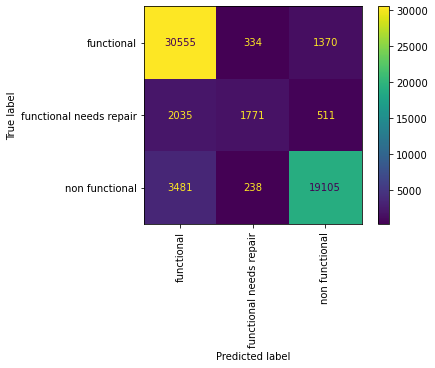

In [558]:
plot_confusion_matrix(final_model,X_train,y_train, xticks_rotation='vertical')

In [560]:
xgboost.XGBClassifier()

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)

In [583]:
test_model = Pipeline([
    ('preprossesing', Preprocessing),
    ('test', RandomForestClassifier(bootstrap=True,
                                     min_samples_split=10,
                                     n_estimators=200,
                                    oob_score=True))
])

test_pipe = Evaluation(test_model,model_name='test',X=X_train, y=y_train)

test_pipe.print_cv_summary()

CV Results for `test` model:
            0.79761 ± 0.00540 accuracy
        


In [584]:
params_rf = {
    'rand_forest__n_estimators':[100,125,150,175,200,225],
    'rand_forest__oob_score':[True],
    'rand_forest__min_samples_split':[8,9,10,11,12]
}

gs_rf = GridSearchCV(estimator=rand_forest_model, param_grid=params_rf, verbose=1)

In [585]:
gs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 45.1min finished


GridSearchCV(estimator=Pipeline(steps=[('preprossesing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_trans',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000203644191F0>),
                                                                        ('cat_trans',
                                                                         Pipeline(steps=[('cat_impute',
  

In [586]:
gs_rf.best_score_

0.7954882154882155

In [587]:
gs_rf.best_params_

{'rand_forest__min_samples_split': 9,
 'rand_forest__n_estimators': 150,
 'rand_forest__oob_score': True}

In [588]:
params_rf = {
    'rand_forest__n_estimators':[130,135,140,145,150,155,160,165],
    'rand_forest__oob_score':[True],
    'rand_forest__min_samples_split':[8,9,10]
}

gs_rf = GridSearchCV(estimator=rand_forest_model, param_grid=params_rf, verbose=1)

In [589]:
gs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 34.9min finished


GridSearchCV(estimator=Pipeline(steps=[('preprossesing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_trans',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000203644191F0>),
                                                                        ('cat_trans',
                                                                         Pipeline(steps=[('cat_impute',
  

In [590]:
gs_rf.best_score_

0.7955218855218854

In [592]:
gs_rf.best_params_

{'rand_forest__min_samples_split': 9,
 'rand_forest__n_estimators': 135,
 'rand_forest__oob_score': True}

In [593]:
final_model = Pipeline([
    ('preprossesing', Preprocessing),
    ('test', RandomForestClassifier(bootstrap=True,
                                     min_samples_split=9,
                                     n_estimators=135,
                                    oob_score=True))
])

final_pipe = Evaluation(final_model,model_name='test',X=X_train, y=y_train)

final_pipe.print_cv_summary()

CV Results for `test` model:
            0.79574 ± 0.00521 accuracy
        


In [600]:
final_model.fit(X_train, y_train)

Pipeline(steps=[('preprossesing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_trans',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000203644191F0>),
                                                 ('cat_trans',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                 

In [601]:
y_pred = final_model.predict(X_test.drop('id', axis=1))

D:\Conda\envs\learn-env\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "


In [602]:
sub.status_group = y_pred

In [607]:
sub.to_csv('submission.csv', index=False)

In [608]:
y_pred

array(['non functional', 'functional', 'functional', ..., 'functional',
       'functional', 'non functional'], dtype=object)